## Scraper

The main task of this part is to scrap the basic information of alumnis. It will use the [API](https://www.mediawiki.org/wiki/API:Main_page) provided by wikipedia to accelerate the scraping process. We will only scrap the introduction part of wiki page.

### Libraries

We just need `json` and `requests` libraries in this part. The only new library you need to install is [tqdm](https://pypi.python.org/pypi/tqdm). It is an easy-to-use progress meter for the python script. Since the number of alumnis are relatively large, tqdm could let us know the exact progress and estimated running time. You can install it using `pip`:

    $ pip install --upgrade tqdm
    
After you finished the installation, please make sure the following commands are workable:

In [2]:
import json
import time
import re
import requests
from tqdm import tqdm
import gensim
import nltk
import string
import scipy
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from FastMap import FastMap, show_cluster, distance
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE
from radar import radar_plt

### Categories
The main resource of alumni list is the [category](https://en.wikipedia.org/wiki/Help:Category) page of wikipedia. For example, the list of [Carnegie Mellon University alumni](https://en.wikipedia.org/wiki/Category:Carnegie_Mellon_University_alumni). Belowing is a dictionary with unviersities' name as keys and with the category name as values. We could manually add any unviersities we want into the dictionary.

In [3]:
universities = dict()
universities['CMU'] = "Category:Carnegie_Mellon_University_alumni"
universities['Stanford'] = "Category:Stanford_University_alumni"
universities['Harvard'] = "Category:Harvard_University_alumni"
universities['Yale'] = "Category:Yale_University_alumni"
universities['UCLA'] = "Category:University_of_California,_Los_Angeles_alumni"
universities['MIT'] = "Category:Massachusetts_Institute_of_Technology_alumni"
universities['Pitt'] = "Category:University_of_Pittsburgh_alumni"

### Collect Tittles Recursively

Using [API:Categorymembers](https://www.mediawiki.org/wiki/API:Categorymembers), we could collect all the titles of alumni in a category page. With parameter `format=json`, we could get the json format as following (`cmlimit=2`):
```python
{
    "batchcomplete": "",
    "continue": {
        "cmcontinue": "page|29374306043f51394d0453454303063f51394d0453454304293743011e01dcc2dcc2dcc3dcbedc06|5648968",
        "continue": "-||"
    },
    "query": {
        "categorymembers": [
            {
                "pageid": 14941891,
                "ns": 0,
                "title": "Gregory Abowd"
            },
            {
                "pageid": 18446374,
                "ns": 0,
                "title": "Linda Addison (poet)"
            }
        ]
    }
}
```
Since the maximum number of titles we could get from one request is 500, we need to use the `continue` parameter. If there is still any remaining members after a request, there would be a `continue` field in the return json. By passing the value of `continue` filed to the `continue` parameter of next request, we could grab all the members recursively. Function `get_members` does that.

In [4]:
def get_members(cat_name, cont=None):
    """
    Return the list of members in given category

    Args:
        cat_name (string): name of category in form as 'Category:Carnegie_Mellon_University_alumni'
        cont (string): value of continue parameter, users should not use it
    Returns:
        ret_val (list): list of all titles of members in this page only
    """
    
    url = 'https://en.wikipedia.org/w/api.php'
    params = {"action" : 'query', 'format' : 'json', 'list' : 'categorymembers', 'cmlimit' : 500, 'cmprop' : 'title'}
    params['cmtitle'] = cat_name
    if (cont != None):
        params['cmcontinue'] = cont
    response = requests.get(url, params=params)
    ret_val = []
    data = json.loads(response.text)
    if ('continue' in data):
        ret_val = get_members(cat_name, cont=data['continue']['cmcontinue'])
    ret_val += [x['title'] for x in data['query']['categorymembers']]
    return ret_val

### Collect Subcategories Recursively

Notice that there are also some subcategories. Using same API, we could grap all subcategories similarly:

In [5]:
def get_all_subcategories(cat_name, cont=None):
    """
    Return the list of all subcategories

    Args:
        cat_name (string): name of category in form as 'Category:Carnegie_Mellon_University_alumni'
        cont (string): value of continue parameter, users should not use it
    Returns:
        ret_val (list): list of all subcategories
    """
        
    url = 'https://en.wikipedia.org/w/api.php'
    params = {"action" : 'query', 'format' : 'json', 'list' : 'categorymembers', 'cmlimit' : 500, 'cmtype' : 'subcat'}
    params['cmtitle'] = cat_name
    if (cont != None):
        params['cmcontinue'] = cont
    response = requests.get(url, params=params)
    ret_val = []
    data = json.loads(response.text)
    if ('continue' in data):
        ret_val = get_all_subcategories(cat_name, cont=data['continue']['cmcontinue'])
    ret_val += [x['title'] for x in data['query']['categorymembers']]
    return ret_val

### Collect All Tittles

Combine the above two functions, we could grab all tittles in a category page, incluing the tittles in the subcategory pages. 

In [6]:
def get_all_members(cat_name):
    """
    Return the list of all members

    Args:
        cat_name (string): name of category in form as 'Category:Carnegie_Mellon_University_alumni'
    Returns:
        ret_val (list): list of all members
    """
    subcategories = get_all_subcategories(cat_name)
    ret_val = []
    for subcat in subcategories:
        ret_val += get_members(subcat)
    ret_val += get_members(cat_name)
    return list(filter(lambda a: not a.startswith("Category:"), ret_val))

### Extract Introduction From a Wiki Page

Now we have a list of tittles contained in a category page, the next step is to grab introduction of every wiki page. We could do that using [API: query/prop=extracts](https://en.wikipedia.org/w/api.php?action=help&modules=query%2Bextracts). With the request 
``` python
'https://en.wikipedia.org/w/api.php?action=query&format=json&prop=extracts&exintro=&explaintext=&titles=Gregory_Abowd|Ross%20Cohen'
```
the returned json is like:
```python
{
    "batchcomplete": "",
    "query": {
        "normalized": [
            {
                "from": "Gregory_Abowd",
                "to": "Gregory Abowd"
            }
        ],
        "pages": {
            "14941891": {
                "pageid": 14941891,
                "ns": 0,
                "title": "Gregory Abowd",
                "extract": "Gregory Dominic Abowd is a computer scientist best known for his work in ubiquitous computing, software engineering, and technologies for autism. He is the J.Z. Liang Professor in the School of Interactive Computing at the Georgia Institute of Technology, where he joined the faculty in 1994."
            },
            "34107971": {
                "pageid": 34107971,
                "ns": 0,
                "title": "Ross Cohen",
                "extract": "Ross Cohen is the cofounder of BitTorrent Inc along with brother Bram Cohen, where among other things he was involved in the Codeville project. He attended Carnegie Mellon University and Stuyvesant High School. He was forced out of the company in 2006."
            }
        }
    }
}
```
Notice that we could connect titles with `|` to get serveral request done at same time. It will greatly improve the efficientcy. The following function `get_info` will do this part.

In [7]:
def get_info(titles):
    """
    Return a dictionary of {title : intro}
    
    Args:
        titles (list of string): list of all titles
    Returns:
        ret_val: a dictionary of {title : intro}
    """
    url = 'https://en.wikipedia.org/w/api.php'
    params = {"action" : 'query', 'format' : 'json', 'prop' : 'extracts', 'exintro' : '', 'explaintext' : ''}
    params['titles'] = titles
    response = requests.get(url, params=params)
    data = list(json.loads(response.text)['query']['pages'].values())
    ret_val = dict()
    for d in data:
        if (d['extract'] != ""):
            ret_val[d['title']] = d['extract']
    return ret_val

### Collect All Data

Finally, we would combine all functions into a single function that grap all alumni's information. The data is formated as a json:
```python
{
    'CMU' : {
        'Kathleen_Carley' : "Kathleen M. Carley is an American social scientist ...""
        ...
    }
    ...
    'University_Name':{
        'Person_Name' : "Text"
    }
}
```

In [8]:
def get_all_info(title_list):
    """
    Return a dictionary of {title : intro}. This function would connect tittles into 
    one request less than 200 characters to improve efficiency.
    
    Args:
        titles (list of string): list of all titles
    Returns:
        ret_val: a dictionary of {title : intro}
    """
    data = dict()
    partial_titles = ""
    for title in tqdm(title_list):
        if len(partial_titles + title) < 200:
            partial_titles += title + '|'
        else:
            partial_titles += title
            info = get_info(partial_titles)
            data = {**data, **info}
            partial_titles = ""
    return data
def get_all_data(universities, append=False):
    """
    dump a data dictionary into data.json file
    
    Args:
        universities(dict) : {university name : alumni list category name}
        append(bool) :  if append is true, the data would be added into existing data dictionary
                        if append is false, the old data would be replaced
    Returns:
        
    """
    data = dict()
    if (append):
        with open('data.json', 'r') as f:
            data = json.load(f)
    for key, value in universities.items():
        print(key)
        data[key] = get_all_info(get_all_members(value))
    with open('data.json', 'w') as fp:
        json.dump(data, fp)

In [9]:
get_all_data(universities)

CMU


100%|████████████████████████████████████████████████████████████████████████████████| 802/802 [00:09<00:00, 87.65it/s]


Stanford


100%|██████████████████████████████████████████████████████████████████████████████| 3872/3872 [00:46<00:00, 83.98it/s]


Harvard


100%|████████████████████████████████████████████████████████████████████████████| 19708/19708 [04:09<00:00, 79.02it/s]


Yale


100%|██████████████████████████████████████████████████████████████████████████████| 7416/7416 [01:32<00:00, 80.53it/s]


UCLA


100%|██████████████████████████████████████████████████████████████████████████████| 2729/2729 [00:31<00:00, 87.39it/s]


MIT


100%|██████████████████████████████████████████████████████████████████████████████| 3003/3003 [00:35<00:00, 84.22it/s]


Pitt


100%|████████████████████████████████████████████████████████████████████████████████| 796/796 [00:09<00:00, 86.75it/s]


### Scrap Academic Disciplines

We also need some "Ground Truth" for different [academic disciplines](https://en.wikipedia.org/wiki/Outline_of_academic_disciplines) in later analysis. We need to import `BeautifulSoup` for this part.

In [10]:
from bs4 import BeautifulSoup

By observing the html of this page, we found that all `h3` tags are the discipline names we want and the link to this discipline is very close to `h3` tag. Thus we could use `BeautifulSoup` to find them.

In [11]:
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL.

    Args:
        url (string): 

    Returns:
        status_code (integer):
        raw_html (string): the raw HTML content of the response, properly encoded according to the HTTP headers.
    """
    response = requests.get(url)
    return (response.status_code, response.text)
    pass
#Scrap Academic Disciplines
outline_url = "https://en.wikipedia.org/wiki/Outline_of_academic_disciplines"
code, html = retrieve_html(outline_url)
soup = BeautifulSoup(html,'html.parser')
body = soup.find('div',{'id':'bodyContent'})
disciplines = dict()
for h3 in body.find_all('h3'):
    dis_name = h3.text[:-6]
    note = h3.next_sibling.next_sibling
    disciplines[dis_name] = []
    if (dis_name == 'Human geography'):
        disciplines[dis_name].append('/wiki/Human_geography')
        continue
    for link in note.find_all('a', href=True):
        url = link.attrs['href']
        if (url.find('Outline')==-1):
            disciplines[dis_name].append(url)
print(disciplines)

{'Arts': ['/wiki/The_arts'], 'History': ['/wiki/History'], 'Languages and literature': ['/wiki/Language', '/wiki/Literature'], 'Philosophy': ['/wiki/Philosophy'], 'Theology': ['/wiki/Theology'], 'Anthropology': ['/wiki/Anthropology'], 'Economics': ['/wiki/Economics'], 'Human geography': ['/wiki/Human_geography'], 'Law': ['/wiki/Law'], 'Political science': ['/wiki/Politics', '/wiki/Political_science'], 'Psychology': ['/wiki/Psychology', '/wiki/List_of_psychology_disciplines'], 'Sociology': ['/wiki/Sociology'], 'Biology': ['/wiki/List_of_life_sciences'], 'Chemistry': ['/wiki/Chemistry'], 'Earth sciences': ['/wiki/Earth_science'], 'Space sciences': [], 'Physics': ['/wiki/Physics'], 'Computer Science': ['/wiki/Computer_science'], 'Mathematics': ['/wiki/Mathematics'], 'Statistics': ['/wiki/Statistics'], 'Engineering and technology': ['/wiki/Engineering'], 'Medicine and health': ['/wiki/Medicine', '/wiki/Healthcare_science']}


In [12]:
data = dict()
for discipline, p_urls in tqdm(disciplines.items()):
    data[discipline] = []
    for url in p_urls:
        time.sleep(0.1)
        code, html = retrieve_html("https://en.wikipedia.org"+url)
        soup = BeautifulSoup(html,'html.parser')
        div = soup.find('div', {"class": "mw-parser-output"})
        text = ""
        for p in div.find_all("p", recursive=False):
            tmp = re.sub("(\[[.*]+\])", "", p.text)
            tmp = re.sub("(\(.*\))", "", tmp).rstrip().strip()
            text += tmp
        data[discipline].append(text)
with open('disciplines.json', 'w') as fp:
        json.dump(data, fp)

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:08<00:00,  2.50it/s]


The `disciplines.json` is formatted as following:
```python
{
    'Discipline Name' : ['Doc1', 'Doc2', ...]
    'Arts' : ['The arts refers to the theory and physical expression of creativity found in human societies and cultures...']
    ...
}
```

## Word Embedding

After we fetched all the alumni data from Wikipedia, what we need to do this part is to transform the alumni's bio texts into high dimentional vectors so that we can do further clustering and Similarity comparison based on it.

### Tokenization
We will first tokenize the texts and remove all the stop words from it, using the nltk library.

In [13]:
# Load alumni data and discipline data from json file
data = json.load(open('data.json'))
discipline = json.load(open('disciplines.json'))
del(discipline['Space sciences'])

In [14]:
def tokenization(text):
    """
    This function takes a a string of text. Then tokenize it as well as remove the stop words.
    
    Args:
        text: a text string
    Returns:
        a list of tokens(words)
    """
    stpwords = stopwords.words('english')
    text = text.lower()
    proc = ''
    i = 0
    while i < len(text):
        c = text[i]
        #remove punctuation
        if c not in string.punctuation:
            proc+=c
        elif c == "'":
            if i == (len(text)-1):
                break
            if text[i+1] == 's' and (i+2) == len(text):
                break
            if text[i+1] == 's' and text[i+2] == ' ':
                i+=1
        else:
            proc+=' '
        i+=1  
    #tokenization by nltk
    tokens = nltk.word_tokenize(proc)
    #remove stop words in tokens
    result = []
    for word in tokens:
        if word not in stpwords:
            result.append(word)
    return result

In [15]:
# Tokenize all alumni data
tokenized_data = {}
for school in data.keys():
    tokenized_data[school] = {}
    for person in data[school].keys():
        tokenized_data[school][person] = tokenization(data[school][person])

In [16]:
with open('tokenized_data.json', 'w') as fp:
    json.dump(tokenized_data, fp)

###  Doc2vec 

Now we need to get the vector of the texts by add up all word vectors from the text.  We will get the vector for each token with [**word2vec**](https://code.google.com/archive/p/word2vec/) using the [**pre-train model**](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) provided by google.

In [17]:
#load google word2vec model
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [18]:
def embedding(tokens, model):
    """
    This function takes a list of tokens(words), and a pretrained word2vec model in gensim.
        Then transform the tokens into a single vector.
    Args: 
        tokens: a list of string representing the tokens
        model: a pretrained word2vec gensim model
    returns:
        vec: a np array representing the tokens.
    """
    vec = None
    for word in tokens:
        #if the model does not contain the word. just skip it
        if word not in model.vocab:
            continue
        if type(vec) != type(None):
            vec = vec + model[word]
        else:
            vec = model[word]
    return vec

In [19]:
processed_data = {}
for school in tokenized_data.keys():
    processed_data[school] = {}
    for person in data[school].keys():
        processed_data[school][person] = embedding(tokenized_data[school][person],model)

In [20]:
np.savez('vec_data.npz', **processed_data)

In [21]:
data_vec = np.load('vec_data.npz')


In [22]:
data_vec = processed_data

### Handling Disciplines

we will do the same techniques as the alumni data to all the discipline data to get the vector of each disciplines.


In [23]:
tokenized_discipline = {}
discipline_vec = {}
for academic in discipline.keys():
    #tokenize 
    tokenized_discipline[academic] = []
    for text in discipline[academic]:
      tokenized_discipline[academic].extend(tokenization(text))
    #doc2vec
    discipline_vec[academic] = embedding(tokenized_discipline[academic],model)
    

In [24]:
np.savez('vec_discipline.npz', **discipline_vec)
with open('tokenized_discipline.json', 'w') as fp:
    json.dump(tokenized_discipline, fp)

## Cosine Similarity

In this part we will use the cosine similarity to get the strength score for each alumni in each adademic fields. A alumni will have a higher score in an academic field if his data vector has a higher cosine similarity with the vector of the academic.

Then we will collect all scores from the alumni from a university and use the mean value as the score for the university.

### Scores: py dict

```
{ <school name1>: {
            <academic>: [[score1, score2, score3, ....],
                     [(name1,score1), (name2,score2), ...]]
              ...
            }
   ...
 }
```

In [25]:
#calculate scores for each alumni
scores = {}
for school in data_vec.keys():
    scores[school] = {}
    for academic in discipline_vec.keys():
        scores[school][academic] = [[],[]]
        displi = discipline_vec[academic]
        for name in data_vec[school].keys():
            alumni = data_vec[school][name]
            scores[school][academic][0].append(1- scipy.spatial.distance.cosine(alumni,displi))
            scores[school][academic][1].append((1- scipy.spatial.distance.cosine(alumni,displi),name))


In [26]:
with open('similarity_score.json', 'w') as fp:
    json.dump(scores, fp)

In [27]:
#get the score for each university
final_scores = {}
for school in scores.keys():
    final_scores[school] = {}
    for academic in scores[school].keys():
        final_scores[school][academic] = np.mean(scores[school][academic][0])
     

In [28]:
#construct the dictionary for plotting
plot_dict = {}
for school in final_scores.keys():
    for academic in final_scores[school].keys():
        if academic not in plot_dict.keys():
            plot_dict[academic] = [[],[]]
        plot_dict[academic][0].append(school)
        plot_dict[academic][1].append(final_scores[school][academic])

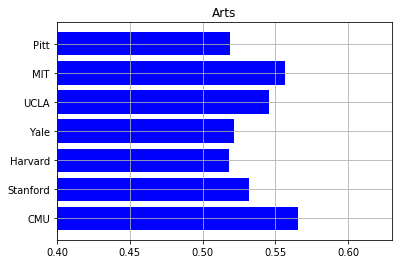

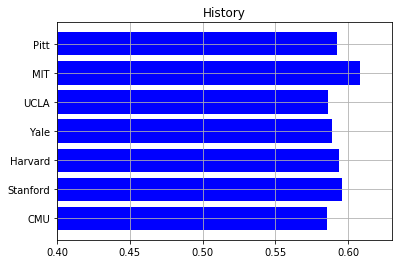

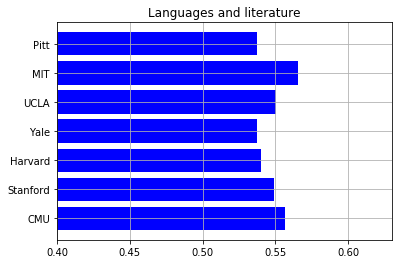

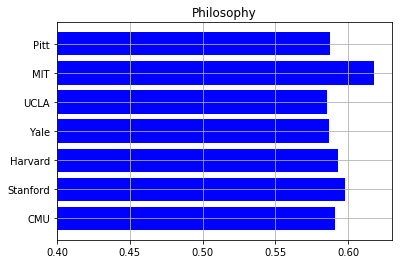

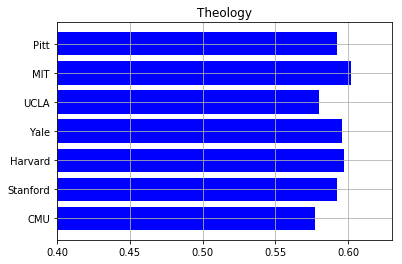

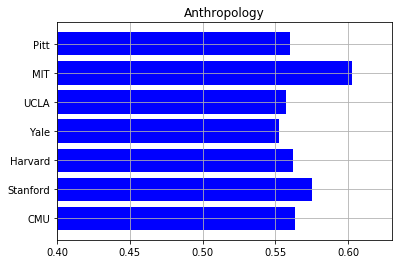

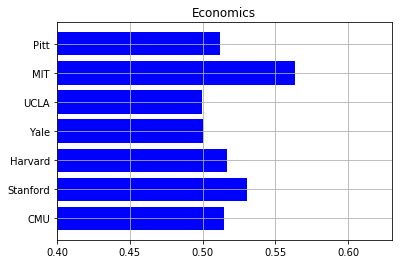

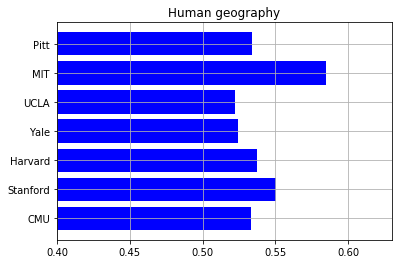

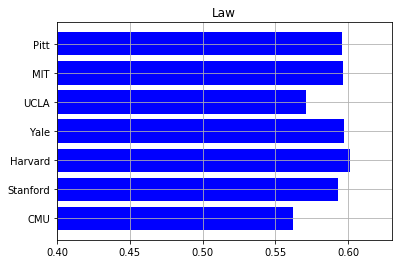

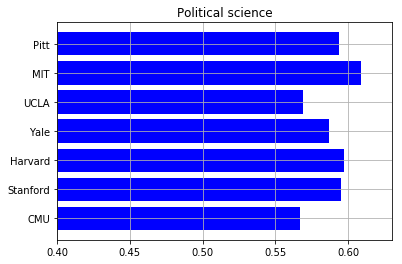

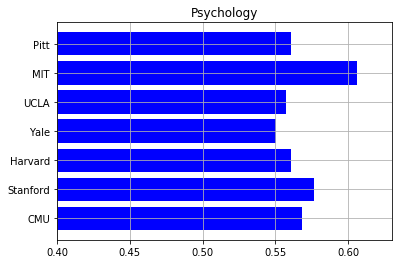

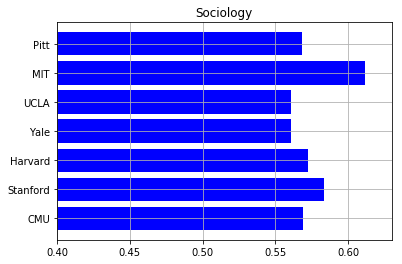

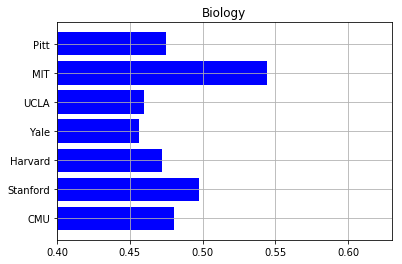

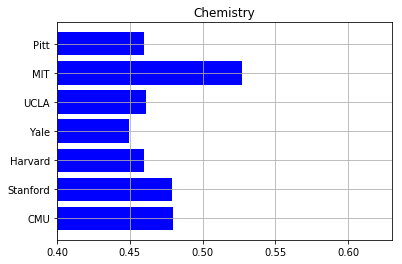

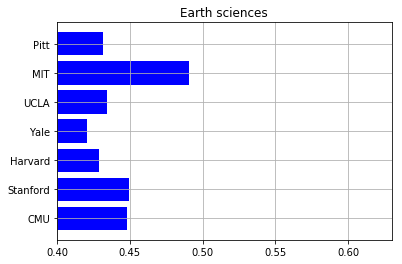

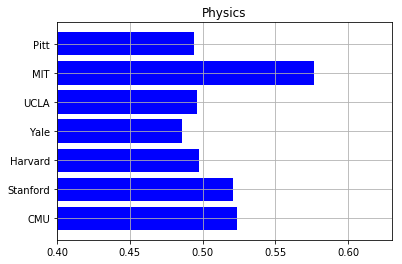

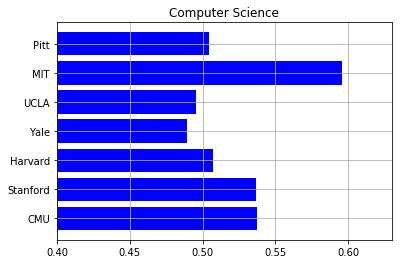

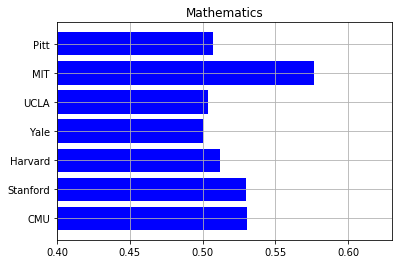

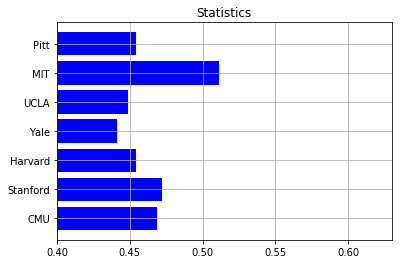

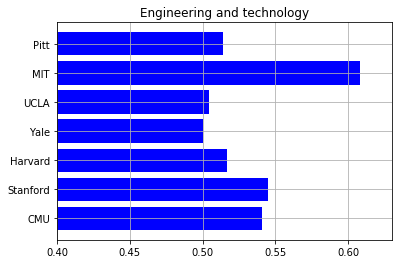

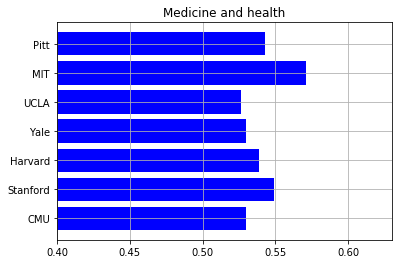

In [29]:
#plot the graphs
for key in plot_dict.keys(): 
    x = plot_dict[key][0]
    y = plot_dict[key][1]
    plt.barh(range(len(x)), y, color = 'b')
    plt.yticks(range(len(x)),x)
    plt.title(key)
    plt.xlim(0.4, 0.63)
    plt.grid()
    plt.show()

In [30]:
data = np.load('vec_data.npz')

## Finding Specialties of Universities

In the previous parts, we have already obtained the document embedding of the alumni and the disciplines. We have also compared universities across different disciplines. In this part, we compare the strengths of the same university in different disciplines, i.e., their specialties.

### Data Preprocessing

To find the specialties of universities, we first organize the document vectors of all the alumni into a single matrix and label them with the universities they belong to. We also need to normalize the document vectors for further processing.

In [31]:
vectors = []
labels = []
names = []
univs = []

for idx, label in enumerate(data):
    univ = data[label][()]
    univs.append(label)
    for name in univ:
        vectors.append(univ[name])
        labels.append(idx)
        names.append(name)
        
vectors = np.asarray(vectors)
vectors = normalize(vectors)

### Clustering of Alumni

We then perform an unsupervised learning on the document vectors of alumni, namely, we cluster the alumni vectors into 100 clusters using Kmeans. The assumption here is that alumni in similar disciplines will have document vectors with larger cosine similarities (after normalization, cosine similarity equals Euclidean distance). If such is the case, we would expect that the alumni corresponding to vectors in a cluster found would be in similar disciplines.

In [32]:
k = 100
kmeans = KMeans(n_clusters=k, random_state=0).fit(vectors)

### Labeling of Clusters

Since clustering is an unsupervied learning task, we have no information about which discipline each cluster corresponds to after performing Kmeans. Rather than finding this out manually, we use the document embedding of the 21 disicpline articles again. We first find the mean of the document vectors in each cluster.

In [33]:
count = np.zeros((len(univs), k))

cluster = {}
cluster_vec = np.zeros((k, vectors.shape[1]))
for i in range(k):
    cluster[i] = []

for (idx, (univ, clst)) in enumerate(zip(labels, kmeans.labels_)):
    count[univ][clst] += 1
    cluster[clst].append(names[idx])
    cluster_vec[clst] += vectors[idx]

cluster_vec = cluster_vec / np.sum(count, axis=0)[:, None]

with open('cluster.json', 'w') as fp:
    json.dump(cluster, fp)

We then normalize the document vectors of the discipline articles. In this way, we get two matrices, one for the means of the alumni clusters and one for the disciplines. We use our assumption again that the cosine similarity between an alumni document and a discipline document indicates the association of the alumni to the discipline. We find the cosine similarity matrix between these two matrices and take the discipline that cluster the mean is closest to as the label of the cluster.

In [34]:
discipline = np.load('vec_discipline.npz')

In [35]:
discipline_vec = []
discs = []

for idx, disc in enumerate(discipline):
    discipline_vec.append(discipline[disc])
    discs.append(disc)
        
discipline_vec = np.asarray(discipline_vec)
discipline_vec = normalize(discipline_vec)

In [36]:
cos_sim = 1 - pairwise_distances(cluster_vec, discipline_vec, metric="cosine")
cos_sim = normalize(cos_sim, axis=0)
tags = np.argmax(cos_sim, axis=1)

In [37]:
rcount = np.zeros((len(univs), len(discs)))
rcluster = {}
rlabels = []

for i in discs:
    rcluster[i] = []

for idx in range(k):
    for univ in range(len(univs)):
        rcount[univ][tags[idx]] += count[univ][idx]
    rcluster[discs[tags[idx]]] += cluster[idx]

for label in kmeans.labels_:
    rlabels.append(tags[label])

with open('rcluster.json', 'w') as fp:
    json.dump(rcluster, fp)

### Discipline Cluster Results

We have already tagged each alumnus with their discipline chosen from the 21 main disciplines given by Wikipedia. Let us inspect tagging of several alumni to see the effect of the unsupervised learning.

In [38]:
t = 20
P = np.random.randint(0, len(names), t)
for p in P:
    print(names[p] +  ':\t' + discs[rlabels[p]])

Stephen Budiansky:	Political science
Henry F. May:	Theology
Standish Lawder:	Arts
George W. Minns:	Law
Tiffany Pham:	Engineering and technology
David G. Johnson:	Economics
Roger D. Kornberg:	Biology
Martín Redrado:	Law
William S. Reyburn:	Law
Amalia Kessler:	Theology
Paula Broadwell:	Economics
Carlos Borunda Zaragoza:	Law
Joseph Robert Wright Jr.:	Law
Mary Kay Bergman:	Arts
Carole Terry:	Arts
Becky Morgan (politician):	Law
Randall Collins:	Anthropology
Peter Silver:	Theology
John Dos Passos:	History
Jochen Küpper:	Chemistry


In the results, we manually find that most of the alumni are assigned correct tags of discipline, indicating that the assumptions of this model are reasonable. However, some alumni tagged with some minor disciplines are misclasified. This is due to that there are too little information for these minor disciplines, and several clusters are mislabled.

We can also plot the alumni vectors colored with their asscociated disciplines. In this part, we use FastMap, PCA, and TSNE to reduce the dimension of the vectors to 2d and plot them out with disciplines.

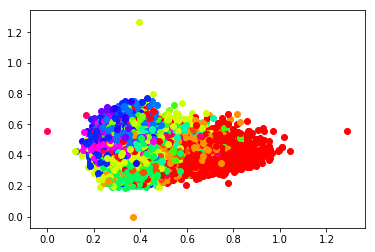

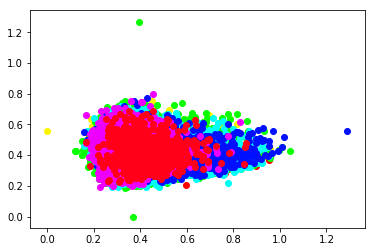

In [39]:
d = 2
dist = euclidean_distances(vectors, vectors)
X2, _ = FastMap(d, dist, vectors.shape[0])
show_cluster(X2, rlabels, d)
show_cluster(X2, labels, d)

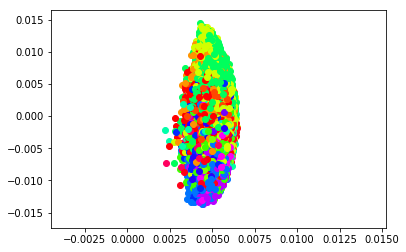

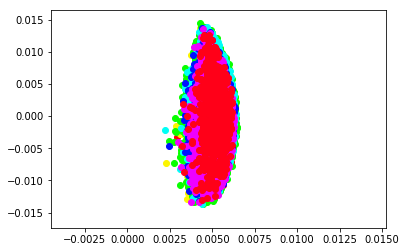

In [40]:
d = 2
pca = PCA(n_components=d)
pca.fit_transform(vectors.T)
show_cluster(pca.components_.T, rlabels, d)
show_cluster(pca.components_.T, labels, d)

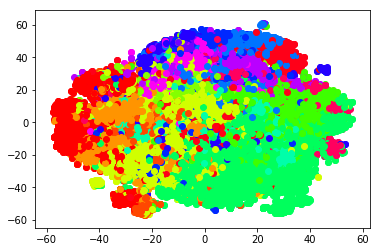

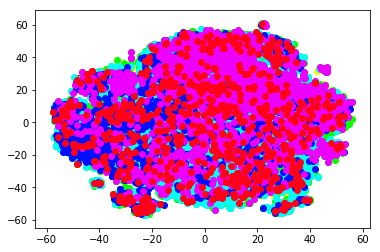

In [41]:
d = 2
tsne = TSNE(n_components=d, random_state=0)
tsne.fit_transform(vectors)
show_cluster(tsne.embedding_, rlabels, d)
show_cluster(tsne.embedding_, labels, d)

Scatter plots obtained by all of the three dimensionality reduction algorithms show some structure of the discipline clusters, further verifying our assumption that document vectors of alumni in similar disciplines have larger cosine similarities.

### Specialties of Universities

With each alumni cluster tagged with a discipline, we can then find the number of alumni in a specific discipline for each university. This time, we assume that the number of alumni in a specific discipline indicates the strength of the university in that disicipline.

We assign the strength of the discipline with the most alumni to be 100 for each university. The strength of other universities are assigned proportional to the number of alumni with respect to the strongest discipline.

We plot the strength of all disciplines in a radar plot for each university.

In [42]:
strength = normalize(rcount, axis=0)
strength /= np.max(strength, axis=1)[:, None]
strength *=  100

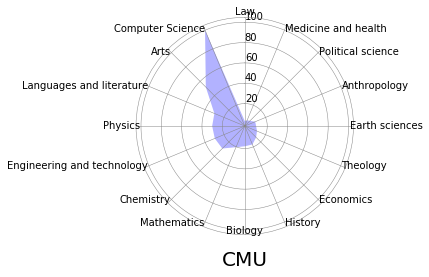

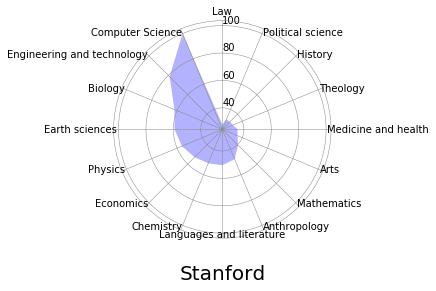

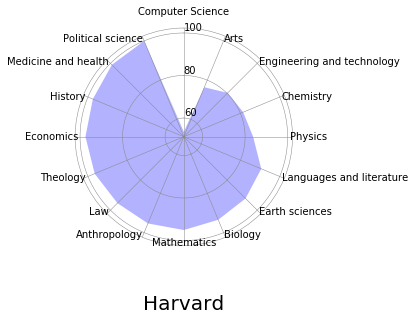

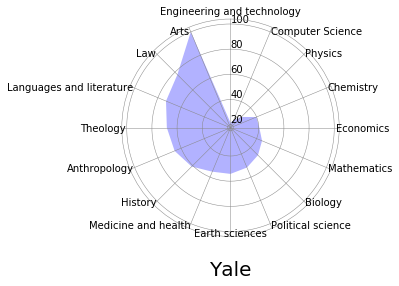

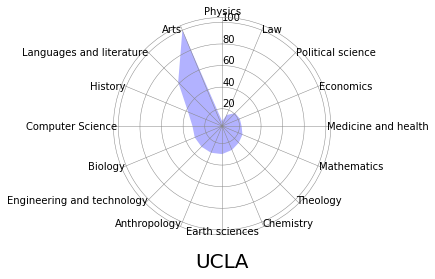

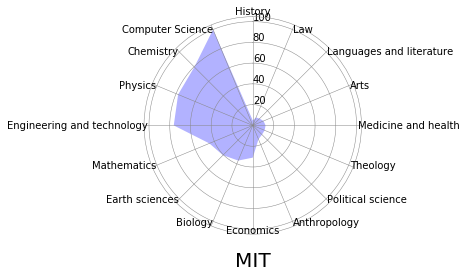

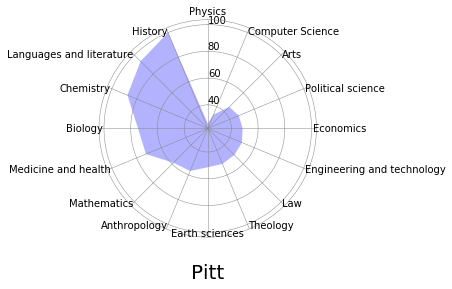

In [43]:
for j in range(strength.shape[0]):
    values = strength[j]
    idxs = np.argsort(values)
    cat = [discs[i] for i in idxs]
    values = np.sort(values)
    tail = len(values) - len(np.nonzero(values)[0])
    cat = cat[tail:]
    values = list(values[tail:])
    radar_plt(cat, values, univs[j])

From the radar plots, we find that CMU is specialized in Computer Science, Arts, and Engineering, which is reasonable. MIT is strong in basically all engineering and application science but relatively weak in liberal arts. University of Pittsburgh is strong in chemistry and medicine. Harvard is strong and balanced in all non-engineering disciplines. All these coincides with basic facts and the public's impression on these universities. The result for other universities are also sound.